# CS 5242 Assignment 8

In this assignment, we are going to dive into autoencoders (AE) and variational autoencoders (VAE). AEs are powerful discriminative models while VAEs are widely used in generation tasks.

### **Submission**

ASSIGNMENT DEADLINE ⏰ : **23:59 09 Nov 2025**

Rename this file as "{StuID}_{Name}_assignment-5.ipynb" (e.g., "A0100000J_John-Doe_assignment-5.ipynb"), and submit it to Canvas. Make sure all outputs are saved in this file as we will not run any code for you. Do **not** submit any other files, especially dataset files.


### **Contact**

Feel free to reach me if you have any question about this assignment.

Slack: Yiqi Zhang

Email: yiqi.zhang@u.nus.edu

## Task 1: Training an autoencoder (AE)
In task 1, the goal is to train an autoencoder (AE), which consists of an encoder and a decoder. AE is capable of learning meaningful representations in the latent space, which could be used for tasks like classification. Let's see how it works.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, hidden_dim),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(1)
        x_enc = self.encoder(x)
        x_dec = self.decoder(x_enc)
        x_recon = x_dec.reshape(B, C, H, W)
        return x_recon

# Instantiate the model
input_dim = 28 * 28
hidden_dim = 32
model = Autoencoder(input_dim, hidden_dim).to(device)

We have prepared the dataset and the AE model for you. Your task is to implement the training code and meet the following requirements:
- use mean squared error (MSE) as the loss function
- use a proper optimizer and a proper learning rate
- train the model for 10 epochs
- plot the training loss curve (at least 10 points in the curve, since we train 10 epochs)

Epoch 1/10: Loss:0.0358 
Epoch 2/10: Loss:0.0143 
Epoch 3/10: Loss:0.0118 
Epoch 4/10: Loss:0.0106 
Epoch 5/10: Loss:0.0099 
Epoch 6/10: Loss:0.0093 
Epoch 7/10: Loss:0.0089 
Epoch 8/10: Loss:0.0086 
Epoch 9/10: Loss:0.0083 
Epoch 10/10: Loss:0.0081 


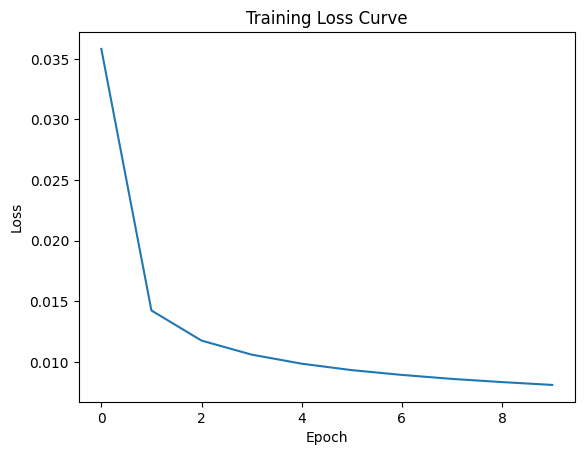

In [2]:
num_epochs = 10

# TODO: train the AE model (2 points)
##############################################
# Your code starts here
##############################################
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
losses = []
for i in range(num_epochs):
    model.train()
    running = 0
    for step, (data, _) in enumerate(train_loader):
        data = data.to(device)
        x_recon = model(data)
        ls = criterion(x_recon, data)
        optimizer.zero_grad()
        ls.backward()
        optimizer.step()
        running += ls.item()*data.size(0)
    epo_loss = running/len(train_dataset)
    losses.append(epo_loss)
    print(f'Epoch {i+1}/{num_epochs}: Loss:{epo_loss:.4f} ')

import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

##############################################
# Your code ends here
##############################################

Verify your AE is well trained by visualizing reconstructed images.

Input Images:


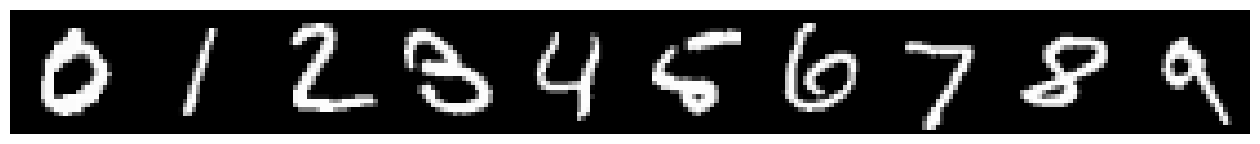

Reconstructed Images:


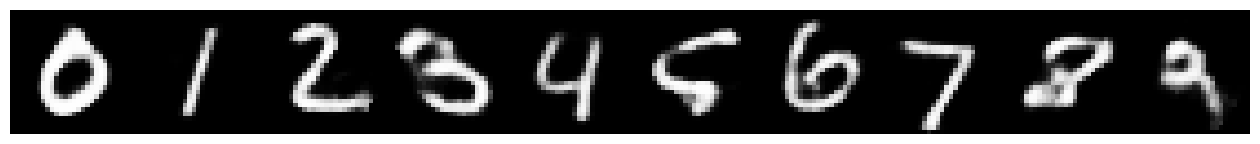

In [3]:
# Visualizing reconstructed images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

sample_list = []
for idx_class in range(10):
    indices_i = (test_dataset.targets == idx_class).nonzero().view(-1)
    idx_sample = indices_i[0]
    sample = test_dataset[idx_sample]
    sample_list.append(sample[0])
x_orig = torch.stack(sample_list).to(device)

# Inference
model.eval()
with torch.no_grad():
    x_recon = model(x_orig)

# Plot the input and reconstructed images
imgs_orig = make_grid(x_orig, nrow=10, padding=0, normalize=True)
imgs_recon = make_grid(x_recon, nrow=10, padding=0, normalize=True)

print('Input Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_orig.permute(1, 2, 0).cpu().numpy(),cmap='gray')
plt.axis('off')
plt.show()

print('Reconstructed Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_recon.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

Now we have trained an AE. Let's see how it can be used for classification. You are required to plot a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) map of the latent representations output by the encoder. Implement the code below and follow these requirements:
- plot a 2D t-SNE map
- plot 20 samples for each class in the **test** set (i.e., 20 points for each digit from 0 to 9)
- use different colors for each digit

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# TODO: Plot t-SNE map (1.5 point)
##############################################
# Your code starts here
##############################################
model.eval()

with torch.no_grad():
    latent_reps = []
    labels = []
    for data, target in test_loader:
        data = data.to(device)
        latent_rep = model.encoder(data.flatten(1))
        latent_reps.append(latent_rep.detach().cpu())
        labels.append(target)

Z = torch.cat(latent_reps).numpy()
y = torch.cat(labels).numpy()

keep_idx = []
for d in range(10):
    idx = np.where(y==d)[0]
    keep_idx.extend(idx[:20])
Z = Z[keep_idx]
y = y[keep_idx]

tsne = TSNE(n_components=2, init = 'pca', learning_rate = 'auto', random_state = 42)
Z_tsne = tsne.fit_transform(Z)

plt.figure(figsize =(8, 6))
sc = plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c = y, cmap = 'tab10')
plt.colorbar(sc)
plt.show()


##############################################
# Your code ends here
##############################################

ModuleNotFoundError: No module named 'sklearn'

Can you see the separation/classification of different digits?

## Task 2: Training a variational autoencoder (VAE)
We have trained an AE in task 1, which is demonstrated to be useful for classification. However, only the encoder of AE is used. The decoder part, which is capable of reconstruction, is wasted. Can we use the decoder for generating images?

The answer is yes. But some modifications are needed to achieve this goal. The general idea is to impose a prior distribution $p(z)$ on the latent space and constrain the learned distribution $q(z|x)$ to be close to $p(z)$, so that we can gain control over the learned latent distribution. Then, we can generate images using the decoder by sampling data points from the latent distribution. Actually, this is all about what a variational autoencoder (VAE) could do.

Typically, people use the standard normal distribution as the prior latent distribution (i.e., $p(z)= N(0, I)$), which has $ \mu=0 $ and $ \sigma=I $.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.mu = nn.Linear(256, latent_dim)
        self.log_var = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(1)

        h = self.encoder(x)

        mu, log_var = self.mu(h), self.log_var(h)
        z = self.reparameterize(mu, log_var)

        x_dec = self.decoder(z)
        x_recon = x_dec.reshape(B, C, H, W)

        return x_recon, mu, log_var

# Instantiate the model
input_dim = 28 * 28
latent_dim = 32
model = VAE(input_dim, latent_dim).to(device)

### Understanding the Reparameterization Trick (1.5 points)

Before implementing the VAE training code, let's understand a critical component: the **reparameterization trick**.

In the VAE model above, you'll notice the `reparameterize` function:
```python
def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std
```

**Question:** In the markdown cell below, answer the following:

1. **What problem does the reparameterization trick solve?** Specifically, explain why we cannot directly sample from `z ~ N(mu, sigma^2)` during training if we want to use backpropagation.

2. **How does the reparameterization trick work?** Explain the mathematical transformation that allows gradients to flow through the sampling operation.

3. **What would happen if we didn't use this trick?** Describe the consequences for training the VAE.


### Your Answer:

**1. What problem does the reparameterization trick solve?**

Directly sampling makes the backpropagation through z impossible using standard chain rule, because the random draw depends on the encoder parameters. This breaks the computational graph, so gradients cannot flow through the sampling operation. The result is we cannot train the encoder with standard backpropagation.

**2. How does the reparameterization trick work?**

The trick rewrites the sampling operation as a deterministic, differentiable transformation of a fixed random variable. eps here provides randomness but is independent of the network parameters, yielding low-variance, pathwise gradient.

**3. What would happen without this trick?**

The encoder would not receive reliable gradients, causing poor or no learning of latent representations.
Training the VAE would often fail to converge or require complex variance-reduction tricks.


Again, We have prepared the dataset and the VAE model for you. Your task is to implement the training code and meet the following requirements:
- The loss function consists of 2 parts: 1) BinaryCrossEntropy (BCE) loss as the reconstruction loss; 2) KL divergence loss to minimize the distance between $q(z|x)$ and $p(z)$. Note that $p(z)= N(0, I)$
- use a proper optimizer and a proper learning rate
- train the model for 10 epochs
- plot the training loss curve (at least 10 points in the curve, since we train 10 epochs)

Epoch 1/20: Loss:166.8356 
Epoch 2/20: Loss:121.2985 
Epoch 3/20: Loss:116.0443 
Epoch 4/20: Loss:111.1986 
Epoch 5/20: Loss:108.5828 
Epoch 6/20: Loss:106.8729 
Epoch 7/20: Loss:105.6037 
Epoch 8/20: Loss:104.6017 
Epoch 9/20: Loss:103.8154 
Epoch 10/20: Loss:103.0504 
Epoch 11/20: Loss:102.5460 
Epoch 12/20: Loss:101.9860 
Epoch 13/20: Loss:101.5831 
Epoch 14/20: Loss:101.2167 
Epoch 15/20: Loss:100.8544 
Epoch 16/20: Loss:100.5185 
Epoch 17/20: Loss:100.2606 
Epoch 18/20: Loss:100.0290 
Epoch 19/20: Loss:99.7994 
Epoch 20/20: Loss:99.5672 


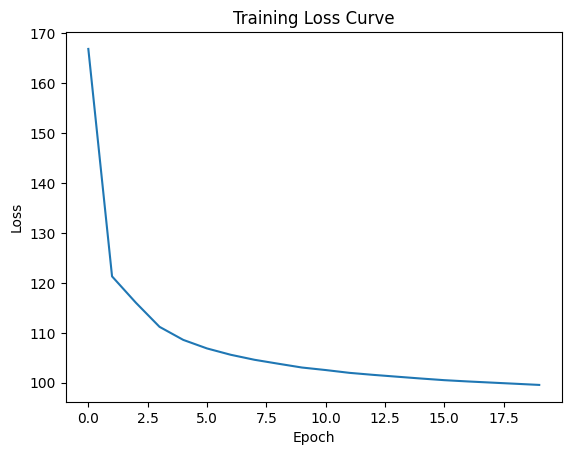

In [ ]:
# TODO: train the VAE model (3 points)
##############################################
# Your code starts here
##############################################
num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
kl_warmup_epochs = 3
beta = 1.0
losses = []

model.train()

for epoch in range(num_epochs):
    running = 0
    for step, (data, _) in enumerate(train_loader):
        data = data.to(device)
        x_prob, mu, log_var = model(data)
        recon = torch.nn.functional.binary_cross_entropy(x_prob, data, reduction="sum") / data.size(0)
        kl = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - 1 -log_var, dim=1).mean()
        warm = min(1.0, (epoch+1)/max(1, kl_warmup_epochs))
        loss = recon + (beta * warm) * kl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item()*data.size(0)
    epo_loss = running/len(train_dataset)
    losses.append(epo_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: Loss:{epo_loss:.4f} ')

plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

##############################################
# Your code ends here
##############################################

Also, verify the sanity of the VAE model by visualizing reconstructed images.

Input Images:


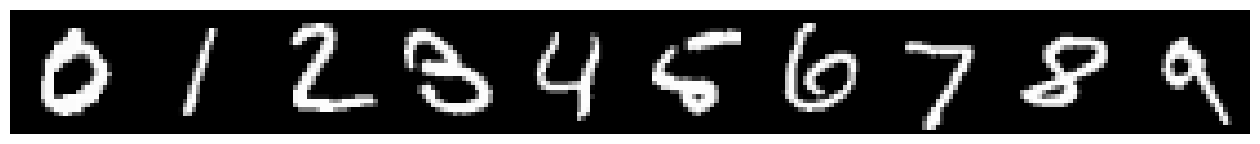

Reconstructed Images:


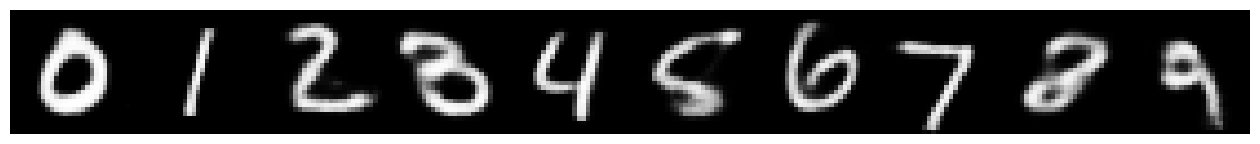

In [ ]:
# Visualizing reconstructed images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

sample_list = []
for idx_class in range(10):
    indices_i = (test_dataset.targets == idx_class).nonzero().view(-1)
    idx_sample = indices_i[0]
    sample = test_dataset[idx_sample]
    sample_list.append(sample[0])
x_orig = torch.stack(sample_list).to(device)

# Inference
model.eval()
with torch.no_grad():
    x_recon, mu, log_var = model(x_orig)

# Plot the input and reconstructed images
imgs_orig = make_grid(x_orig, nrow=10, padding=0, normalize=True)
imgs_recon = make_grid(x_recon, nrow=10, padding=0, normalize=True)

print('Input Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_orig.permute(1, 2, 0).cpu().numpy(),cmap='gray')
plt.axis('off')
plt.show()

print('Reconstructed Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_recon.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

Now we have trained a VAE. Let's first check its latent distribution like we do for AE. You are required to plot a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) map of the latent representations output by the VAE encoder. Implement the code below and follow these requirements:
- plot a 2D t-SNE map
- plot 20 samples for each class in the **test** set (i.e., 20 points for each digit from 0 to 9)
- use different colors for each digit

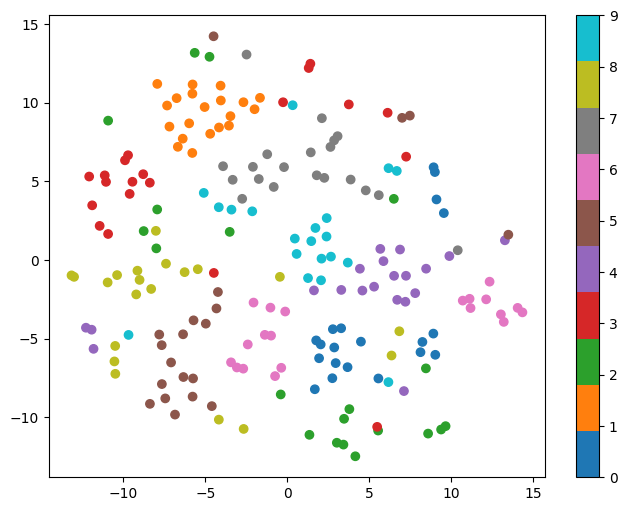

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# TODO: Plot t-SNE map (1.5 point)
##############################################
# Your code starts here
##############################################
model.eval()

with torch.no_grad():
    latent_reps = []
    labels = []
    for data, target in test_loader:
        data = data.to(device)
        x_recon, mu, log_var = model(data)
        latent_reps.append(mu.cpu())
        labels.append(target)

Z = torch.cat(latent_reps).numpy()
y = torch.cat(labels).numpy()

keep_idx = []
for i in range(10):
    idx = np.where(y==i)[0]
    keep_idx.extend(idx[:20])
Z = Z[keep_idx]
y = y[keep_idx]

tsne = TSNE(n_components=2, init = 'pca', learning_rate = 'auto', random_state = 42)
Z_tsne = tsne.fit_transform(Z)

plt.figure(figsize =(8, 6))
sc = plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c = y, cmap = 'tab10')
plt.colorbar(sc)
plt.show()

##############################################
# Your code ends here
##############################################

Finally, we are able to generate images using the decoder of the VAE by sampling data points from $p(z)$. Implement the code below and meet these requirements:
- sample 10 data points from $p(z)$
- show them 5 images in a row, 2 rows in total
- at least one image should be recognized as a digit

Generate Images:


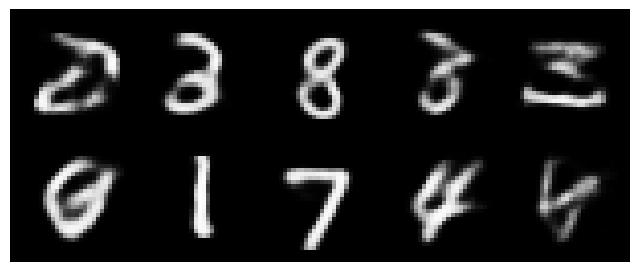

In [ ]:
# TODO: generate digits using the decoder of VAE (1 point)
##############################################
# Your code starts here
##############################################
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

model.eval()
num_samples = 10
torch.manual_seed(42)
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim, device=device)
    x_prob = model.decoder(z)
    if x_prob.dim() == 2 and x_prob.size(1) == 784:
        x_prob = x_prob.view(-1, 1, 28, 28)

    imgs_gen = make_grid(x_prob, nrow=5, padding=2)

    print('Generate Images:')
    plt.figure(figsize=(8, 8))
    plt.imshow(imgs_gen.permute(1, 2, 0).cpu().numpy(),cmap='gray')
    plt.axis('off')
    plt.show()

##############################################
# Your code ends here
##############################################

## Ablation Study: Beta-VAE (3 points)

Now that you've trained a standard VAE, let's explore how the balance between reconstruction and KL divergence affects model performance. The VAE loss function is:

$$\mathcal{L} = \text{Reconstruction Loss} + \beta \times \text{KL Divergence}$$

When $\beta = 1$, this is the standard VAE. When $\beta \neq 1$, we have a **Beta-VAE**, which can lead to different properties:
- **Lower β (< 1)**: Prioritizes reconstruction quality over latent regularization
- **Higher β (> 1)**: Prioritizes latent regularization, potentially leading to better disentanglement

**Your Task:** Train three VAE variants and compare them:
1. **Beta-VAE with β = 0.5** (prioritize reconstruction)
2. **Standard VAE with β = 1.0** (balanced - you may reuse your previous model)
3. **Beta-VAE with β = 2.0** (prioritize regularization)

**Requirements:**
- Train each variant for 10 epochs with the same hyperparameters (optimizer, learning rate, etc.)
- Plot the **total loss curves** for all three models on the **same plot** with a legend
- Generate **10 random samples** from each trained model (3 sets of 10 images total)
- Show the generated images in a grid (you can use subplots: 3 rows × 10 columns, or separate grids)


Beta:0.5 Epoch 1/10: Loss:160.3945 
Beta:0.5 Epoch 2/10: Loss:110.2016 
Beta:0.5 Epoch 3/10: Loss:102.9291 
Beta:0.5 Epoch 4/10: Loss:97.1852 
Beta:0.5 Epoch 5/10: Loss:94.2552 
Beta:0.5 Epoch 6/10: Loss:92.5425 
Beta:0.5 Epoch 7/10: Loss:91.3992 
Beta:0.5 Epoch 8/10: Loss:90.4650 
Beta:0.5 Epoch 9/10: Loss:89.7186 
Beta:0.5 Epoch 10/10: Loss:89.2145 
Beta:1.0 Epoch 1/10: Loss:166.3894 
Beta:1.0 Epoch 2/10: Loss:122.4739 
Beta:1.0 Epoch 3/10: Loss:117.2917 
Beta:1.0 Epoch 4/10: Loss:111.8355 
Beta:1.0 Epoch 5/10: Loss:108.7417 
Beta:1.0 Epoch 6/10: Loss:106.8066 
Beta:1.0 Epoch 7/10: Loss:105.3729 
Beta:1.0 Epoch 8/10: Loss:104.3234 
Beta:1.0 Epoch 9/10: Loss:103.5704 
Beta:1.0 Epoch 10/10: Loss:102.8538 
Beta:2.0 Epoch 1/10: Loss:172.9804 
Beta:2.0 Epoch 2/10: Loss:133.3820 
Beta:2.0 Epoch 3/10: Loss:133.1582 
Beta:2.0 Epoch 4/10: Loss:129.7096 
Beta:2.0 Epoch 5/10: Loss:127.2494 
Beta:2.0 Epoch 6/10: Loss:125.6016 
Beta:2.0 Epoch 7/10: Loss:124.3541 
Beta:2.0 Epoch 8/10: Loss:123.300

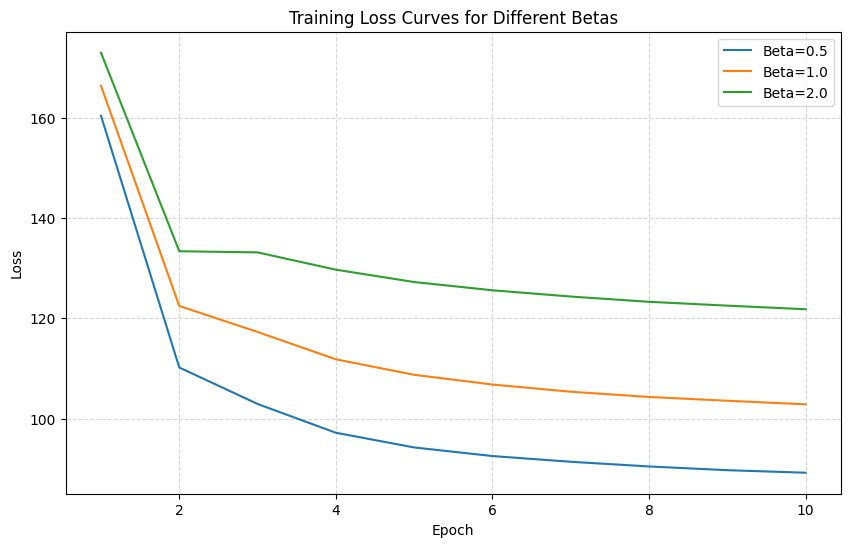

Generate Images - Beta=0.5:


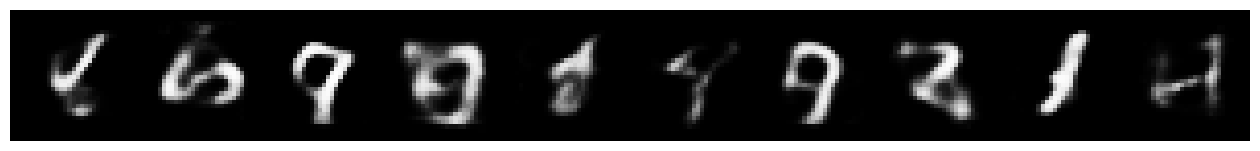

Generate Images - Beta=1.0:


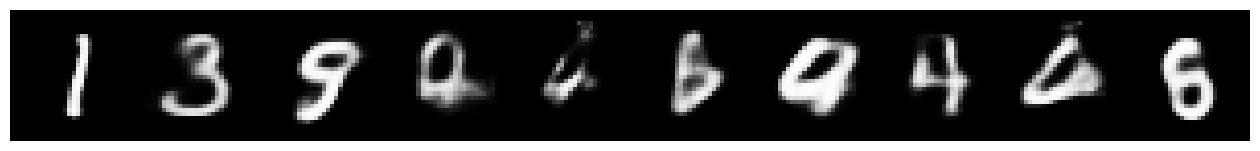

Generate Images - Beta=2.0:


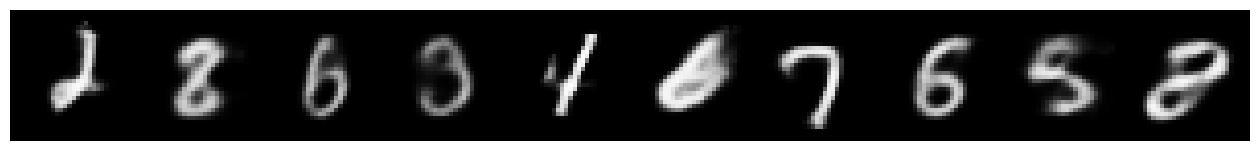

In [ ]:
# TODO: Implement Beta-VAE ablation study
##############################################
# Your code starts here
##############################################

# Hint: You may want to modify the VAE class to accept a beta parameter
# or create three separate training loops with different beta values
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def train(beta = 1.0, num_epochs = 10):
    input_dim = 28 * 28
    latent_dim = 32
    model = VAE(input_dim, latent_dim).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    kl_warmup_epochs = 3
    losses = []

    model.train()

    for epoch in range(num_epochs):
        running = 0
        for step, (data, _) in enumerate(train_loader):
            data = data.to(device)
            x_prob, mu, log_var = model(data)
            recon = torch.nn.functional.binary_cross_entropy(x_prob, data, reduction="sum") / data.size(0)
            kl = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - 1 -log_var, dim=1).mean()
            warm = min(1.0, (epoch+1)/max(1, kl_warmup_epochs))
            loss = recon + (beta * warm) * kl

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running += loss.item()*data.size(0)
        epo_loss = running/len(train_dataset)
        losses.append(epo_loss)
        print(f'Beta:{beta} Epoch {epoch+1}/{num_epochs}: Loss:{epo_loss:.4f} ')
    return model, losses

betas = [0.5, 1.0, 2.0]
losses = []
models = []
num_epochs = 10
for beta in betas:
    model, loss = train(beta=beta, num_epochs=num_epochs)
    losses.append(loss)
    models.append(model)

plt.figure(figsize=(10, 6))
for i in range(len(betas)):
    plt.plot(range(1, num_epochs+1), losses[i], label=f'Beta={betas[i]}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Betas')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Train beta=0.5 model

# Train beta=1.0 model (or reuse from previous section)

# Train beta=2.0 model

# Plot loss curves for all three models on the same plot

# Generate and display 10 samples from each model
with torch.no_grad():
    torch.manual_seed(42)
    z = torch.randn(10, latent_dim, device=device)
    for i in range(len(betas)):
        model = models[i]
        model.eval()
        x_prob = model.decoder(z)
        if x_prob.dim() == 2 and x_prob.size(1) == 784:
            x_prob = x_prob.view(-1, 1, 28, 28)

        imgs_gen = make_grid(x_prob, nrow=10, padding=2)

        print(f'Generate Images - Beta={betas[i]}:')
        plt.figure(figsize=(16, 8))
        plt.imshow(imgs_gen.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.show()

##############################################
# Your code ends here
##############################################


### Analysis and Comparison (Required)

Based on your experiments above, answer the following questions:

**1. Loss Curve Analysis:**
Compare the loss curves of the three models. Which model converged to the lowest loss? Does lower loss always mean better performance? Explain.

**Answer**: β=0.5 converged to the lowest loass.

No.Lower loss doesn't always mean better performance.

The VAE loss function is a weighted sum of two competing goals (Reconstruction loss and KL diverge). A smaller beta places less weight on KL divergence and focuses on pixel-level reconstruction, the model is able to focus almost entirely on minimizing the Reconstruction Loss. That does not mean the model generalizes or samples better.

**2. Generated Image Quality:**
Compare the quality and diversity of generated images across the three models. Which β value produces the best-looking digits? Which produces the most diverse samples? Provide specific observations.

**Answer**: Comparison:

- β=0.5 produced the most fragmented and distorted digits, often containing artifacts. These samples were the most unrecognizable, indicating severe under-regularization of the latent space.

- β=1.0 generated moderately clear digits with reasonable diversity, representing a good balance between image quality and latent regularization.

- β=2.0 produced the highest semantic recognizability (most complete and trustworthy shapes), demonstrating superior latent space structure.

β=2.0 produces best semantic recognizability.
β=2.0 produces the diverse samples.

**3. Trade-off Analysis:**
Explain the trade-off between reconstruction quality and latent space regularization. Based on your results, which β value would you recommend for this task and why?

**Answer**:
 - High β: Emphasizes strong regularization to achieve a highly structured latent space and robust shapes, potentially at the cost of some fine-grained pixel details.

 - Low β: Emphasizes high fidelity reconstruction, resulting in a chaotic, unusable latent space.

I would recommend β=1.0 to get a balance performance between reconstruction quality and latent space regularization.


## Task 3: Try Vector Quantized Variational Autoencoder (VQ-VAE) (Bonus: 5 points)

More realisticly, images can have more discrete categories. In this task, we will try to use Vector Quantized Variational Autoencoder (VQ-VAE) to generate images. VQ-VAE is a variant of VAE that uses a discrete latent space.

With the backbone of VAE, VQ-VAE introduces a codebook $𝐶$ to quantize the latent space. Specifically, instead of directly encoding a continuous latent variable $z$, VQ-VAE enforces that the latent representations are drawn from a finite set of discrete codes in the codebook $C$. During encoding, each latent vector is replaced by its nearest neighbor in the codebook, introducing quantization to the latent space. This process allows the model to learn a discrete, compact representation of the data.

Please refer to this [link](https://shashank7-iitd.medium.com/understanding-vector-quantized-variational-autoencoders-vq-vae-323d710a888a) for more details.

### Implementation tips

1. **Codebook**: Use nn.Embedding to implement the codebook. The weights should be initialized with a uniform distribution.
2. **Quantization**: Given the continuous latent representation $z_e$, compute distances $d^2 = z^2 + e^2 - 2 e * z$. Then, find the index of the nearest neighbor in the codebook. Use tensor.detach() to prevent gradients from flowing through the codebook.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.

    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.codebook = nn.Embedding(n_e, e_dim)# TODO: define the codebook
        # TODO: initialize the codebook
        nn.init.uniform_(self.codebook.weight, -1.0 / n_e, 1.0 / n_e)

    def forward(self, z_f):
        # TODO:
        ## 1. Compute the distance between flattend latent z_f and the embedding vectors
        ## 2. Find the closest encodings
        ## 3. Get the quantized latent vectors
        ##############################################
        # Your code starts here
        ##############################################
        d = torch.sum(z_f**2, dim=1, keepdim=True) + torch.sum(self.codebook.weight**2, dim=1) - 2 * torch.matmul(z_f, self.codebook.weight.t())
        encoding_indices = torch.argmin(d, dim=1)
        z_q = self.codebook(encoding_indices)
        ##############################################
        # Your code ends here
        ##############################################

        return z_q

The backbone of the VQ-VAE model has been implemented for you and hyperparameters are set. Please implement the VectorQuantizer and the training code.

In [ ]:
import torch.nn.functional as F

class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1,
                      stride=1, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        return x

class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x


class Encoder(nn.Module):
    """
    This is the q_theta (z|x) network. Given a data sample x q_theta
    maps to the latent space x -> z.

    For a VQ VAE, q_theta outputs parameters of a categorical distribution.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel-1,
                      stride=stride-1, padding=1),
            ResidualStack(
                h_dim, h_dim, res_h_dim, n_res_layers)

        )

    def forward(self, x):
        return self.conv_stack(x)

class Decoder(nn.Module):
    """
    This is the p_phi (x|z) network. Given a latent sample z p_phi
    maps back to the original space z -> x.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 3, kernel_size=kernel,
                               stride=stride, padding=1)
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)

class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, res_latent_dim, n_res_layers, embedding_dim, codebook_size, beta=0.25):
        super(VQVAE, self).__init__()
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size
        self.beta = beta

        # Encoder
        self.encoder = Encoder(3, latent_dim, n_res_layers, res_latent_dim)

        # Vector quantization
        self.pre_quantization_conv = nn.Conv2d(latent_dim, embedding_dim, kernel_size=1, stride=1)
        self.vector_quantization = VectorQuantizer(
            codebook_size, embedding_dim, beta)

        # Decoder
        self.decoder = Decoder(embedding_dim, latent_dim, n_res_layers, res_latent_dim)

    def forward(self, x):
        # Encode
        z_e = self.encoder(x)
        z_e = self.pre_quantization_conv(z_e)

        # Quantize
        B, C, H, W = z_e.shape
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        z_f = z_e.view(-1, C)
        z_q = self.vector_quantization(z_f)
        z_q = z_q.view(B, H, W, -1)
        codebook_loss = torch.mean((z_q.detach()-z_e)**2) + self.beta * \
            torch.mean((z_q - z_e.detach()) ** 2)
        z_q = z_e + (z_q - z_e).detach()    # Prevent backpropagation to codebook
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        # Decode
        x_recon = self.decoder(z_q)

        return x_recon, z_e, z_q, codebook_loss

# Instantiate the model
input_dim = 3 * 32 * 32
latent_dim = 128
res_latent_dim = 32
n_res_layers = 2
embedding_dim = 64
codebook_size = 512

model = VQVAE(input_dim, latent_dim, res_latent_dim, n_res_layers, embedding_dim, codebook_size).to(device)

To demonstrate the effectiveness of VQ-VAE, we adopt CIFAR-10 dataset in this task.

In [ ]:
# Using CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])


batch_size = 128

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

The training pipeline is similar to VAE.

In [ ]:
# TODO: train the VQ-VAE model
##############################################
# Your code starts here
##############################################
num_epochs = 20
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion_mse = nn.MSELoss(reduction='mean')
sigmoid_activation = nn.Sigmoid()

model.train()

for epoch in range(num_epochs):
    running = 0.0
    for step, (data, _) in enumerate(train_loader):
        print(f'Training dataset Step={step}, Min:{data.min()}, Max: {data.max()}')
        data = data.to(device)
        x_recon, z_e, z_q, codebook_loss = model(data)
        x_recon_activated = sigmoid_activation(x_recon)
        # recon_loss = torch.nn.functional.binary_cross_entropy_with_logits(x_recon, data, reduction='sum')/data.size(0)
        # recon_loss = criterion_mse(x_recon, data)
        recon_loss = torch.nn.functional.l1_loss(x_recon, data)
        loss = recon_loss + codebook_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()*data.size(0)
        # print(f'Epoch:{epoch}/{num_epochs}, Step:{step}, Loss:{running:.4f}')


    epo_loss = running/len(train_dataset)

    print(f'Epoch:{epoch+1}/{num_epochs}, Loss:{epo_loss:.4f}')
##############################################
# Your code ends here
##############################################


Epoch:1/2000, Loss:0.1986
Epoch:2/2000, Loss:0.0825
Epoch:3/2000, Loss:0.0702
Epoch:4/2000, Loss:0.0623
Epoch:5/2000, Loss:0.0590
Epoch:6/2000, Loss:0.0578
Epoch:7/2000, Loss:0.0575
Epoch:8/2000, Loss:0.0564
Epoch:9/2000, Loss:0.0562
Epoch:10/2000, Loss:0.0562
Epoch:11/2000, Loss:0.0561
Epoch:12/2000, Loss:0.0556
Epoch:13/2000, Loss:0.0553
Epoch:14/2000, Loss:0.0549
Epoch:15/2000, Loss:0.0547
Epoch:16/2000, Loss:0.0544
Epoch:17/2000, Loss:0.0543
Epoch:18/2000, Loss:0.0544
Epoch:19/2000, Loss:0.0539
Epoch:20/2000, Loss:0.0538
Epoch:21/2000, Loss:0.0536
Epoch:22/2000, Loss:0.0534
Epoch:23/2000, Loss:0.0532
Epoch:24/2000, Loss:0.0531
Epoch:25/2000, Loss:0.0529
Epoch:26/2000, Loss:0.0528
Epoch:27/2000, Loss:0.0525
Epoch:28/2000, Loss:0.0525
Epoch:29/2000, Loss:0.0525
Epoch:30/2000, Loss:0.0522
Epoch:31/2000, Loss:0.0523
Epoch:32/2000, Loss:0.0521
Epoch:33/2000, Loss:0.0519
Epoch:34/2000, Loss:0.0520
Epoch:35/2000, Loss:0.0519
Epoch:36/2000, Loss:0.0517
Epoch:37/2000, Loss:0.0518
Epoch:38/2

We can evaluate the model by checking the reconstruction loss and the generated images. Please run the code below to generate images for assessment.

Input Images:


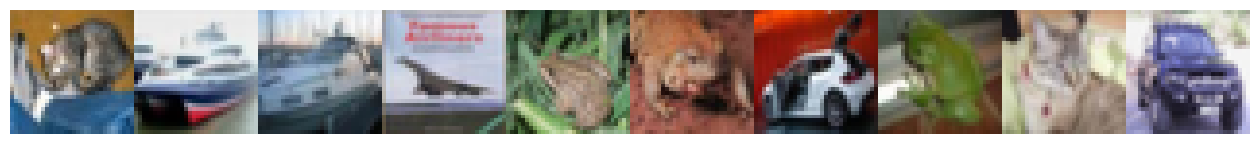

Reconstructed Images:


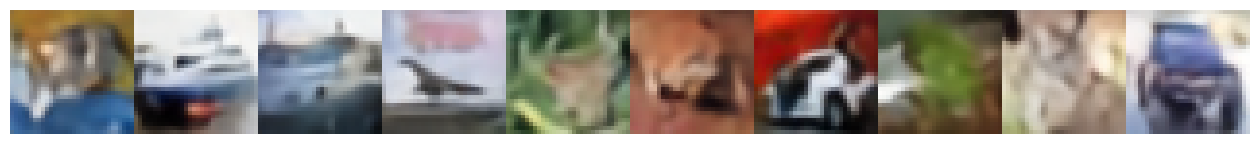

In [ ]:
# Visualizing reconstructed images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

sample_list = []
batch = next(iter(test_loader))
for i in range(10):
    sample_list.append(batch[0][i])
x_orig = torch.stack(sample_list).to(device)

# Inference
model.eval()
with torch.no_grad():
    x_recon, mu, log_var, _ = model(x_orig)

# Plot the input and reconstructed images
imgs_orig = make_grid(x_orig, nrow=10, padding=0, normalize=True)
imgs_recon = make_grid(x_recon, nrow=10, padding=0, normalize=True)

print('Input Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_orig.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

print('Reconstructed Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_recon.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()